# Example of visualization of slope directions

To try this example, download [a sample data package](https://arcspace.jp/lib/exe/fetch.php?media=aigis2:itokawa_sample_for_pyaigis.zip) and place an unzipped folder with the same place as this notebook. The sample data is originally prepared as an sample data for the stand-alone application version of [AiGIS](https://arcspace.jp/doku.php?id=aigis:top), and a gravity vector data is added.

## 1. Import required modules

In [1]:
import pyvista as pv
import pyvistaqt as pvqt
import vtk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import spiceypy as spice

## 2. Load shape models in the OBJ format

In [2]:
obj_low = "./Itokawa_sample/Shapemodel/Itokawa_49152.obj"
mesh_low = pv.read(obj_low)

## 3. Define a function to generate lat/lon grid data

In [3]:
def latlon_grid(mesh, lat_interval, lon_interval):
    lat_grid = {}
    lon_grid = {}
    
    plane = pv.Plane(direction=(0,0,1)).triangulate()
    cutter = vtk.vtkCutter()
    implicitFunction = vtk.vtkImplicitPolyDataDistance()
    implicitFunction.SetInput(plane)
    cutter.SetInputData(mesh)
    cutter.SetCutFunction(implicitFunction)
    
    lat_grid[0] = cutter
    
    for lat in range(0, 90, lat_interval):
        if lat != 0:
            cone1 = pv.Cone(center=(0,0,0.5),direction=(0,0,-1),angle=lat, resolution=30).triangulate()
            cone = pv.Cone(center=(0,0,-0.5),direction=(0,0,1),angle=lat, resolution=30).triangulate()

            cutter = vtk.vtkCutter()
            implicitFunction = vtk.vtkImplicitPolyDataDistance()
            implicitFunction.SetInput(cone)
            cutter.SetInputData(mesh)
            cutter.SetCutFunction(implicitFunction)
            
            cutter1 = vtk.vtkCutter()
            implicitFunction1 = vtk.vtkImplicitPolyDataDistance()
            implicitFunction1.SetInput(cone1)
            cutter1.SetInputData(mesh)
            cutter1.SetCutFunction(implicitFunction1)
            

            lat_grid[lat] = cutter1
            lat_grid[lat*(-1)] = cutter
            
            
    for lon in range(0, 180, lon_interval):
        plane = pv.Plane(direction=(1, math.tan(math.radians(lon)), 0)).triangulate()
        
        cutter = vtk.vtkCutter()
        implicitFunction = vtk.vtkImplicitPolyDataDistance()
        implicitFunction.SetInput(plane)
        cutter.SetInputData(mesh)
        cutter.SetCutFunction(implicitFunction)
        
        lon_grid[lon] = cutter
        

    lat_grid = dict(sorted(lat_grid.items()))
    
    return lat_grid, lon_grid

### 3.1. Generate lat/lon grid data from shape models

In [4]:
lat_grid, lon_grid = latlon_grid(mesh_low, 10, 10)

## 4. Load mapdata (geographic information) from data files to a Pandas Dataframe

In [5]:
mapdata = pd.DataFrame() 

In [6]:
mapdata_dir = "./Itokawa_sample/MapData/"
for mapdata_file in glob.glob(mapdata_dir + "*.txt"):
    print(mapdata_file)
    with open(mapdata_file,'r') as file:
        data_count = file.readlines()[2]
        fin = int(data_count) + 3
    file.close()
    
    
    map = []
    
    
    with open(mapdata_file,'r') as file:
    
        for  line in file.readlines()[3:fin]:
            row = []
            toks = line.split()
            if toks[1] == '-' :
                map.append(np.nan)
            else:
                map.append(float(toks[1]))

    file.close()
    map = np.array(map)
    
    file = open(mapdata_file, 'r')
    label = file.readline()
    label = label.replace("\n","")
    file.close()
    mapdata[label] = map

./Itokawa_sample/MapData/Itokawa_elevation_64.txt
./Itokawa_sample/MapData/AMICA_brightness.txt
./Itokawa_sample/MapData/Lidar_Shot_count.txt
./Itokawa_sample/MapData/itokawa_Gpotential20110111.txt
./Itokawa_sample/MapData/itokawa_slope20110111.txt
./Itokawa_sample/MapData/NIRS_ch30_11_1_13.txt
./Itokawa_sample/MapData/st_2422543206_v_map64.txt


### Examine a mapdata

In [7]:
mapdata

,Elevation,AMICA_Brightness,LIDAR_Shot_count,Gravitational_Potential,Surface_Slope,NIRS_Albedo,st_2422543206
0,-3.451888,2208.0,12.0,1.332124e-08,8.327451,0.136988,NaN
1,-3.431725,2320.0,14.0,1.331943e-08,9.677955,0.137103,NaN
2,-3.906290,2400.0,18.0,1.336465e-08,19.696030,0.137116,NaN
3,-4.018442,2304.0,6.0,1.337372e-08,16.515810,0.137244,NaN
4,-4.496425,2320.0,21.0,1.341490e-08,8.457731,0.137221,NaN
...,...,...,...,...,...,...,...
49147,-13.372890,2672.0,5.0,1.402295e-08,20.296640,0.139043,NaN
49148,-13.574630,2576.0,5.0,1.403639e-08,16.779950,0.139327,NaN
49149,-13.981460,2528.0,9.0,1.407219e-08,18.056780,0.139327,NaN
49150,-13.653220,2592.0,4.0,1.404182e-08,17.979880,0.138906,NaN


## 5. Load gravity data

In [8]:
Gravitydata = pd.read_csv('Itokawa_sample/itokawa_f49152_GFandSlope.txt', 
                       delimiter='\s', skiprows=4)

/var/folders/m9/x28f0x012kbbydh8tn4hnrx80000gn/T/ipykernel_20548/1108171328.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Gravitydata = pd.read_csv('Itokawa_sample/itokawa_f49152_GFandSlope.txt',


In [9]:
Gravitydata

,#PlateID,center.x,center.y,center.z,lon,lat,CRefAccx,CRefAccy,CRefAccz,attract.x,attract.y,attract.z,Gpotential,Rpotential,Tpotential,GeopotentialSlope,normal.x,normal.y,normal.z,area
0,1,-0.148537,0.081457,0.076603,151.259886,24.331928,-0.000003,0.000002,-0.0,-0.000033,0.000035,0.000062,0.013671,0.000297,-0.013968,6.260537,-4.5145,5.0240,11.1246,6507265.0
1,2,-0.149840,0.080393,0.076493,151.785203,24.220273,-0.000003,0.000002,-0.0,-0.000033,0.000034,0.000062,0.013669,0.000299,-0.013968,7.982436,-4.8619,4.1643,11.1513,6429054.0
2,3,-0.148107,0.078897,0.077597,151.955698,24.816165,-0.000003,0.000002,-0.0,-0.000033,0.000033,0.000063,0.013716,0.000291,-0.014007,18.443100,-4.8328,1.6968,12.0296,6537323.0
3,4,-0.149430,0.077813,0.077280,152.492459,24.640911,-0.000003,0.000002,-0.0,-0.000034,0.000033,0.000063,0.013725,0.000294,-0.014019,14.918880,-4.3567,2.5695,11.7776,6408881.0
4,5,-0.147713,0.076320,0.078403,152.675666,25.246555,-0.000003,0.000002,-0.0,-0.000033,0.000032,0.000064,0.013767,0.000286,-0.014053,6.367602,-4.3964,4.5831,11.1073,6397368.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49147,49148,0.131493,0.060710,-0.051203,24.782601,-19.470384,0.000003,0.000001,-0.0,0.000011,0.000050,-0.000046,0.014391,0.000217,-0.014608,19.045090,-1.4872,10.7068,-6.5806,6327551.0
49148,49149,0.131150,0.061600,-0.049990,25.159031,-19.034732,0.000003,0.000001,-0.0,0.000011,0.000051,-0.000045,0.014405,0.000217,-0.014622,14.760820,-1.0098,7.5186,-7.4946,5331934.0
49149,49150,0.129317,0.061783,-0.049520,25.536967,-19.061357,0.000003,0.000001,-0.0,0.000011,0.000052,-0.000045,0.014442,0.000213,-0.014654,16.121110,-1.1637,7.3077,-6.7669,5013672.0
49150,49151,0.130610,0.062860,-0.048533,25.700588,-18.512056,0.000003,0.000001,-0.0,0.000011,0.000052,-0.000044,0.014410,0.000217,-0.014628,16.078900,-1.1208,6.9655,-5.8137,4570927.0


## 6. Prepear gravity and slope data to show

In [10]:
Gravity = Gravitydata.filter(items=['attract.x', 'attract.y', 'attract.z'], axis=1).to_numpy()

In [11]:
normal = Gravitydata.filter(items=['normal.x', 'normal.y', 'normal.z'], axis=1).to_numpy()

In [12]:
centers = mesh_low.cell_centers()
# centers = Gravitydata.filter(items=['center.x', 'center.y', 'center.z'], axis=1).to_numpy()

In [13]:
prjGrav = np.empty((0,3))
# normal = np.empty((0,3))
# slope = []
for i in range(0,len(Gravitydata),1):
    tmp = [spice.vhat(spice.vprjp(Gravity[i]*(-1), spice.nvc2pl(normal[i].tolist(), 0.0)))]
    prjGrav=np.append(prjGrav, tmp, axis=0)
#     normal=np.append(normal, [itokawa.polygon['normal'][i]], axis=0)
#     slope = np.append(slope, spice.vsep(Gravity[i], itokawa.polygon['normal'][i])*spice.dpr())

In [14]:
centers["prjGrav"] = prjGrav
centers["Gravity"] = Gravity
centers["normal"] = normal
centers["slope"] = Gravitydata.filter(items=['GeopotentialSlope'], axis=1).to_numpy()

## 7. Visualize slope direction

### 7.1. Prepare PyVista glyph to be visualized

In [15]:
arrows_Gravity = centers.glyph(orient="Gravity", factor=100.0, tolerance=0.02)
arrows_prjGrav = centers.glyph(orient="prjGrav", scale="slope", factor=0.001, tolerance=0.005)
arrows_prjGrav_1 = centers.glyph(orient="prjGrav", scale="slope", factor=0.0005, tolerance=0.005)
arrows_normal = centers.glyph(orient="normal", factor=0.01, tolerance=0.02)

### 7.2. Visualize slope direction (inline view)
- Color, length and weight of arrows: slope value
- Direction of arrows: slope direction

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/homebrew/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


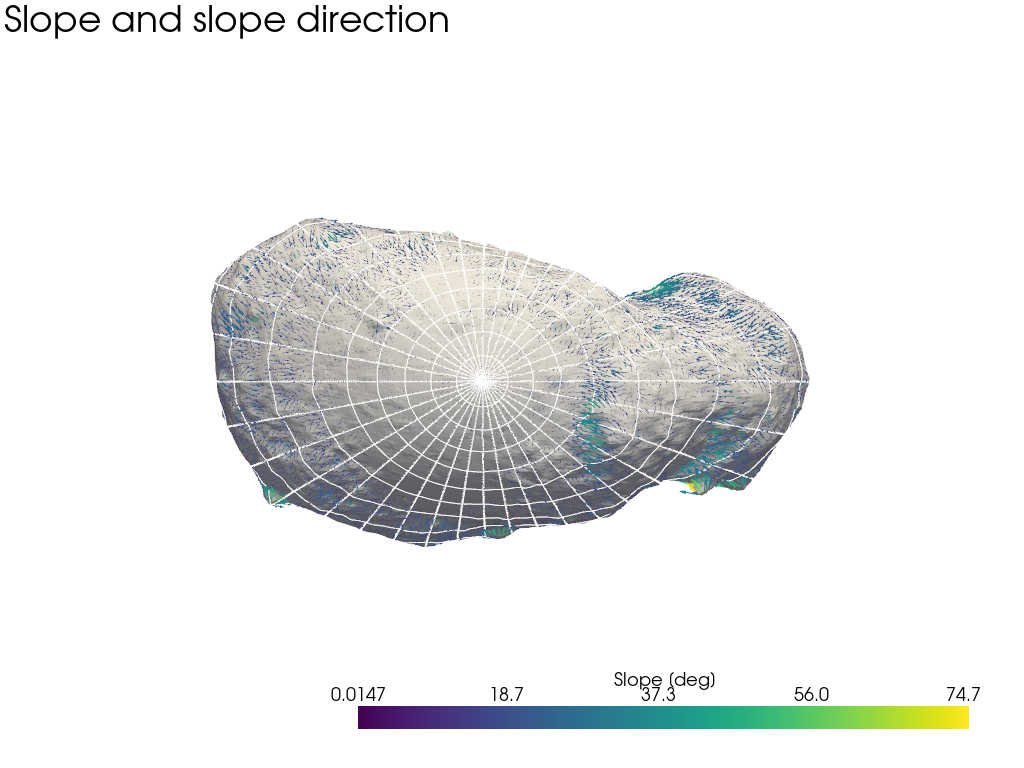

In [16]:
# p = pv.Plotter(notebook=False)
p = pv.Plotter()
p.add_text('Slope and slope direction', font_size=16)
p.add_mesh(arrows_prjGrav_1, lighting=False, scalar_bar_args={'title': "Slope [deg]"})
p.add_mesh(mesh_low, color="w")
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.view_xy()
p.show()

### 7.3 Make a dummy PyVistaQt window to avaid crush of python kernel on macOS environment
ipykernel will crush when a separate window with "notebook=False" is made by PyVista pv.Plotter and close it on macOS environment.
Curiously, this problem can be suppressed once a separate window is made by PyVistaQt pvqt.BackgroundPlotter before to call PyVista pv.Plotter. You can close the PyVistaQt window before proceed.

In [17]:
pq = pvqt.BackgroundPlotter(notebook=False)

### 7.4. Visualize slope direction (interactive view)
- Color, length and weight of arrows: slope value
- Direction of arrows: slope direction

In [18]:
p = pv.Plotter(notebook=False)
# p = pv.Plotter()
p.add_text('Slope and slope direction', font_size=16)
p.add_mesh(arrows_prjGrav_1, lighting=False, scalar_bar_args={'title': "Slope [deg]"})
p.add_mesh(mesh_low, color="w")
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.view_xy()
p.show()

This will obtain a view like [this snapshot](./img/Itokawa_SlopeVectors.png).

## Reference
- Plotting Glyphs (Vectors or PolyData) in PyVista Tutorial https://tutorial.pyvista.org/tutorial/04_filters/solutions/e_glyphs.html